In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
import glob

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [3]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
####### Loading Data #########

import os
from glob import glob
from zipfile import ZipFile

data_path = '/content/drive/MyDrive/Noisy_images.zip' 
with ZipFile(data_path, 'r') as f:
  f.extractall()

folder_path = '/content/Noisy_images'
train_path = folder_path + "/Train/"
test_path = folder_path + "/Test"

print(os.listdir(folder_path))

folders = glob(folder_path + "/Train/*")
print(folders)
print("no of classes:",len(folders))

['Test', 'Train']
['/content/Noisy_images/Train/Guassian', '/content/Noisy_images/Train/Motion artifacts', '/content/Noisy_images/Train/Poisson', '/content/Noisy_images/Train/Salt and pepper']
no of classes: 4


In [5]:
########## Data Augmentation #############

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  #  shear_range = 0.2,
                                  #  zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = False,
                                   data_format = 'channels_last',
                                   dtype = tf.float32)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 36, # Entire Dataset
                                                 color_mode = 'rgb',
                                                 class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 14,
                                            color_mode = 'rgb',
                                            class_mode = 'categorical')



Found 72 images belonging to 4 classes.
Found 28 images belonging to 4 classes.


(36, 224, 224, 3)
(36, 4)
[0. 0. 1. 0.]


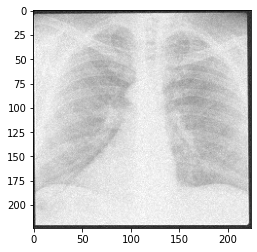

In [6]:
x,y = training_set[0]
print(x.shape)
print(y.shape)

idx = 0
plt.imshow(x[idx])
print(y[idx])

In [22]:
########### CNN Model 1.0 ###########
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

def model1(summary = False):
  weight_decay = 1e-2
  num_classes = 4

  model = Sequential()

  model.add(Conv2D(32, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(224,224,3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(32, (4,4), padding='same', ))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))


  model.add(Flatten())
  model.add(Dense(64, activation="sigmoid"))
  model.add(Activation('relu'))
  model.add(Dense(num_classes, activation='softmax'))
  # model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.0003), metrics=['accuracy'])
  if summary == True:
    model.summary()
  else:
    pass
  
  return model


def model2(summary = False):
  cnn = tf.keras.models.Sequential()

  # Step 1 - Convolution
  cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 3]))

  # Step 2 - Pooling
  cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

  # Adding a second convolutional layer
  cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
  cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
  cnn.add(tf.keras.layers.Dropout(0.2))

  cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
  cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
  cnn.add(tf.keras.layers.Dropout(0.2))

  cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
  cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

  # Step 3 - Flattening
  cnn.add(tf.keras.layers.Flatten())

  # Step 4 - Full Connection
  cnn.add(tf.keras.layers.Dense(units=100, activation='relu'))
  cnn.add(tf.keras.layers.Dropout(0.2))
  cnn.add(tf.keras.layers.Dense(units=50, activation='relu'))
  cnn.add(tf.keras.layers.Dropout(0.2))

  # Step 5 - Output Layer
  cnn.add(tf.keras.layers.Dense(units=4, activation='sigmoid'))
  if summary == True:
    cnn.summary()
  else:
    pass
  
  return cnn

In [17]:
def eval(model, opti, epcs, training_set, test_set):

  model.compile(optimizer = opti, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  log = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=epcs,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
  )

  import matplotlib.pyplot as plt

  plt.figure(figsize = (12,8))
  plt.subplot(1,2,1)
  plt.plot(log.history['loss'])
  plt.plot(log.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  
  plt.subplot(1,2,2)
  plt.plot(log.history['accuracy'])
  plt.plot(log.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
2/2 [==============================] - 2s 791ms/step - loss: 1.4836 - accuracy: 0.2083 - val_loss: 1.3752 - val_accuracy: 0.2500
Epoch 2/40
2/2 [==============================] - 1s 508ms/step - loss: 1.3564 - accuracy: 0.2639 - val_loss: 1.3705 - val_accuracy: 0.2500
Epoch 3/40
2/2 [==============================] - 1s 519ms/step - loss: 1.3878 - accuracy: 0.2639 - val_loss: 1.3641 - val_accuracy: 0.2500
Epoch 4/40
2/2 [==============================] - 1s 524ms/step - loss: 1.3426 - accuracy: 0.3472 - val_loss: 1.3672 - val_accuracy: 0.4643
Epoch 5/40
2/2 [==============================] - 1s 524ms/step - loss: 1.3735 - accuracy: 0.2222 - val_loss: 1.3568 - val_accuracy: 0.2500
Epoch 6/40
2/2 [==============================] - 1s 525ms/step - loss: 1.3122 - accuracy: 0.3750 - val_loss: 1.3355 - val_accuracy: 0.2857
Epoch 7/40
2/2 [==============================] - 1s 529ms/step - loss: 1.3063 - accuracy: 0.2778 - val_loss: 1.3388 - val_accuracy: 0.5714
Epoch 8/40
2/2 [====

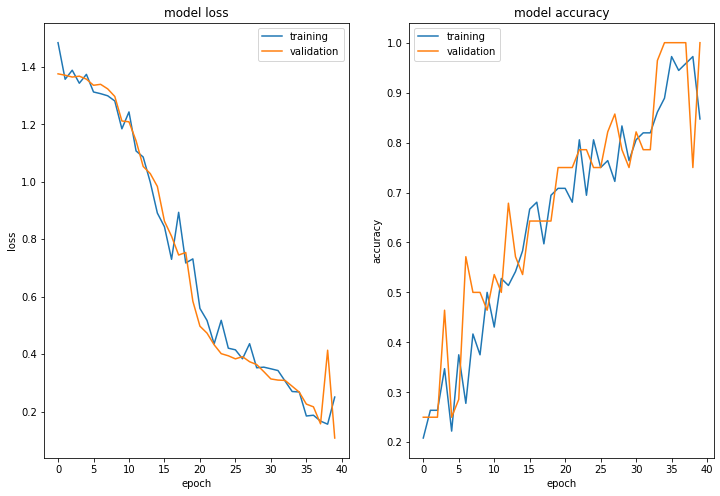

In [24]:
model = model2()
eval(model,'adam', 40, training_set, test_set)

In [32]:

model.save('model_25_4_dataset.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
2/2 [==============================] - 3s 1s/step - loss: 1.0629 - accuracy: 0.4815 - val_loss: 3.0490 - val_accuracy: 0.1429
Epoch 2/20
2/2 [==============================] - 1s 712ms/step - loss: 0.2415 - accuracy: 0.9722 - val_loss: 2.7277 - val_accuracy: 0.3571
Epoch 3/20
2/2 [==============================] - 1s 706ms/step - loss: 0.2006 - accuracy: 0.9815 - val_loss: 3.3663 - val_accuracy: 0.2500
Epoch 4/20
2/2 [==============================] - 1s 713ms/step - loss: 0.2261 - accuracy: 0.9630 - val_loss: 3.2856 - val_accuracy: 0.2500
Epoch 5/20
2/2 [==============================] - 1s 695ms/step - loss: 0.1707 - accuracy: 0.9815 - val_loss: 2.7950 - val_accuracy: 0.3571
Epoch 6/20
2/2 [==============================] - 1s 709ms/step - loss: 0.1950 - accuracy: 0.9630 - val_loss: 2.8318 - val_accuracy: 0.3571
Epoch 7/20
2/2 [==============================] - 1s 709ms/step - loss: 0.1363 - accuracy: 1.0000 - val_loss: 2.8062 - val_accuracy: 0.1786
Epoch 8/20
2/2 [=======

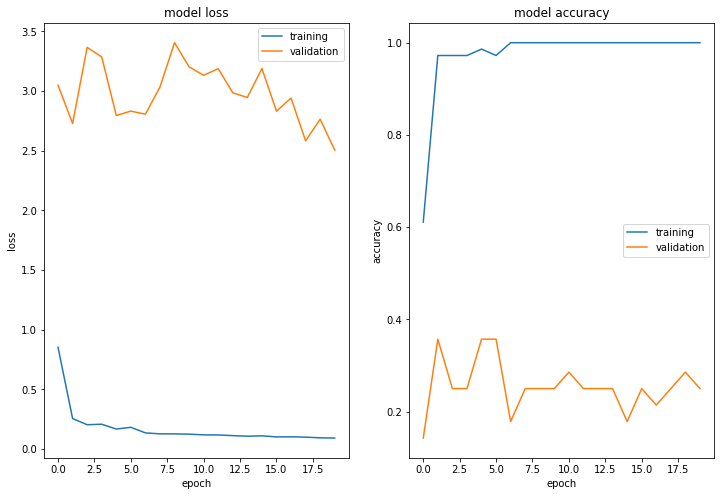

In [19]:
model = model1()
eval(model,'adam', 20, training_set, test_set)